In [46]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [47]:
data_dir = "../data/processed"
image_dir = "../images"

In [48]:
df_cmpds_original = pd.read_pickle(os.path.join(data_dir, "BBBC021_original_compounds_fps.pickle"))

In [49]:
df_cmpds_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 3 to 112
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Image_Metadata_Compound  35 non-null     object
 1   Image_Metadata_MoA       35 non-null     object
 2   Image_Metadata_SMILES    35 non-null     object
 3   mol                      35 non-null     object
 4   morgan_fp                35 non-null     object
dtypes: object(5)
memory usage: 1.6+ KB


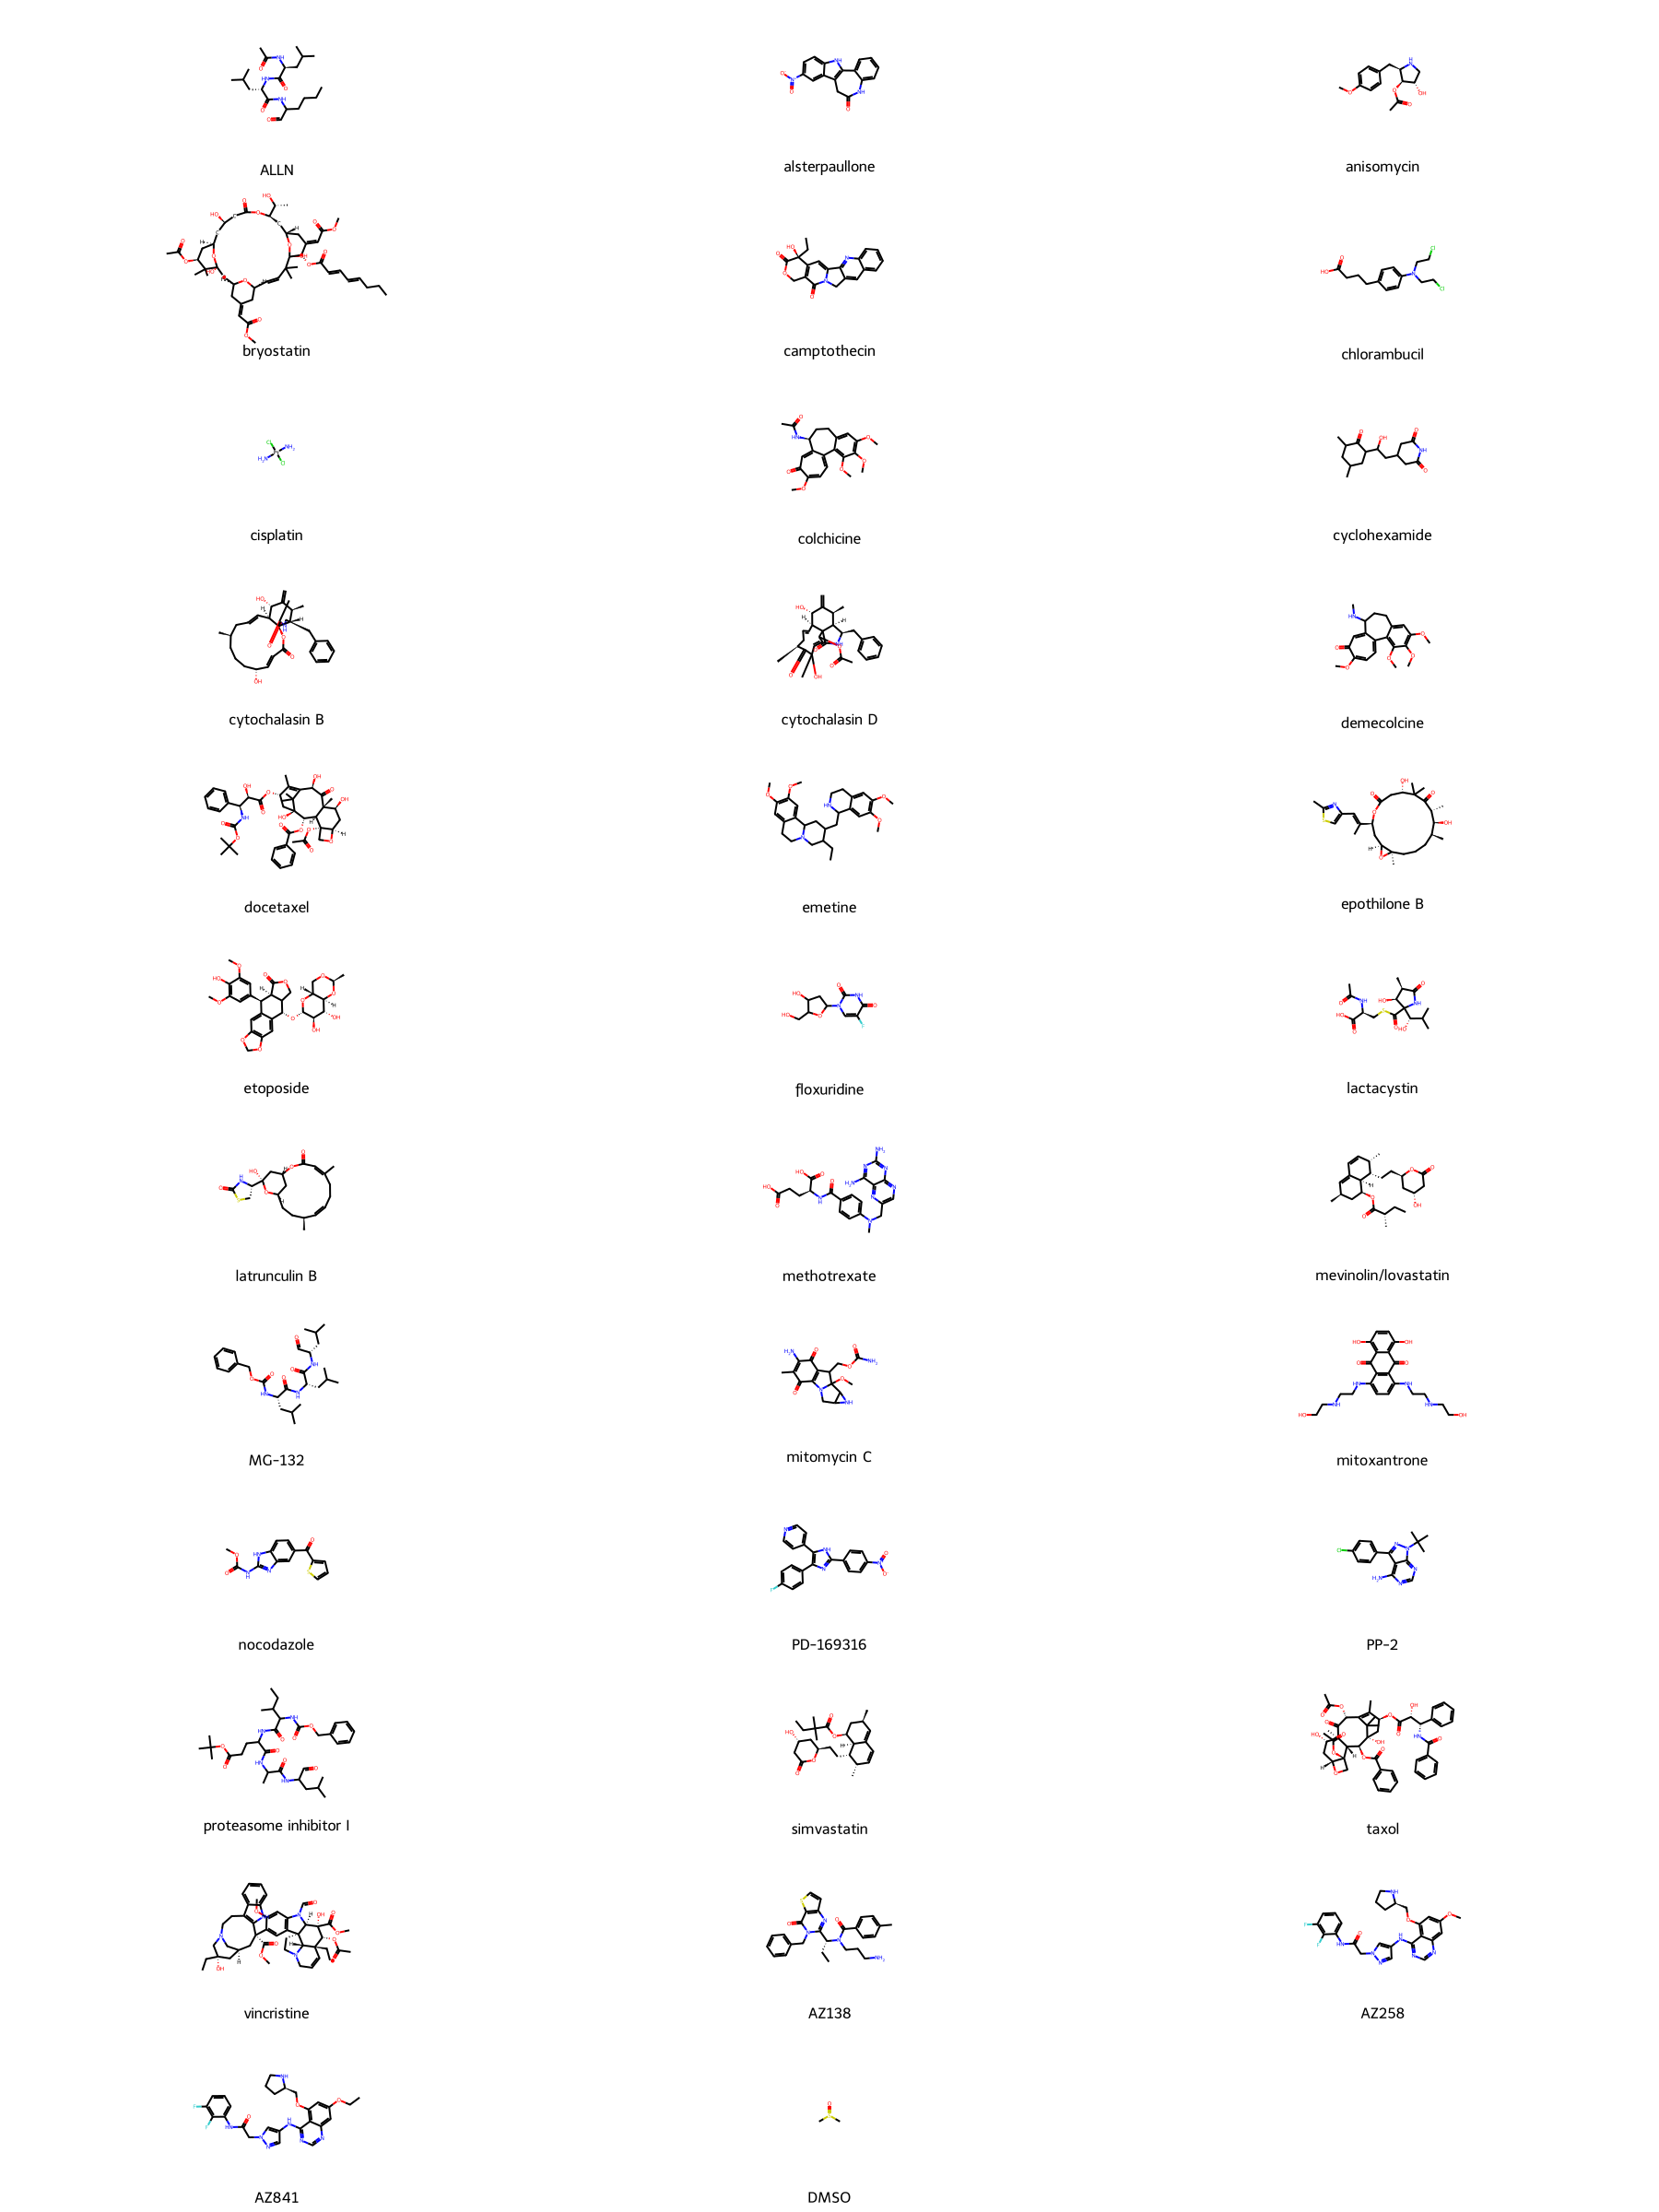

In [50]:
Draw.MolsToGridImage(
    df_cmpds_original["mol"].to_list(),
    molsPerRow=3,
    subImgSize=(600, 200),
    legends=df_cmpds_original["Image_Metadata_Compound"].to_list(),
)

In [51]:
compounds = df_cmpds_original["Image_Metadata_Compound"].to_numpy()
fingerprints = df_cmpds_original["morgan_fp"].to_numpy()
moas = df_cmpds_original["Image_Metadata_MoA"].unique()

In [52]:
def create_fp_sim_matix(fps):
    sim_matrix = np.zeros((len(fps), len(fps)))

    for i in range(len(fps)):
        for j in range(len(fps)):
            sim_matrix[i][j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return sim_matrix

In [53]:
similarity_matrix = create_fp_sim_matix(fingerprints)
distance_matrix = 1 - similarity_matrix

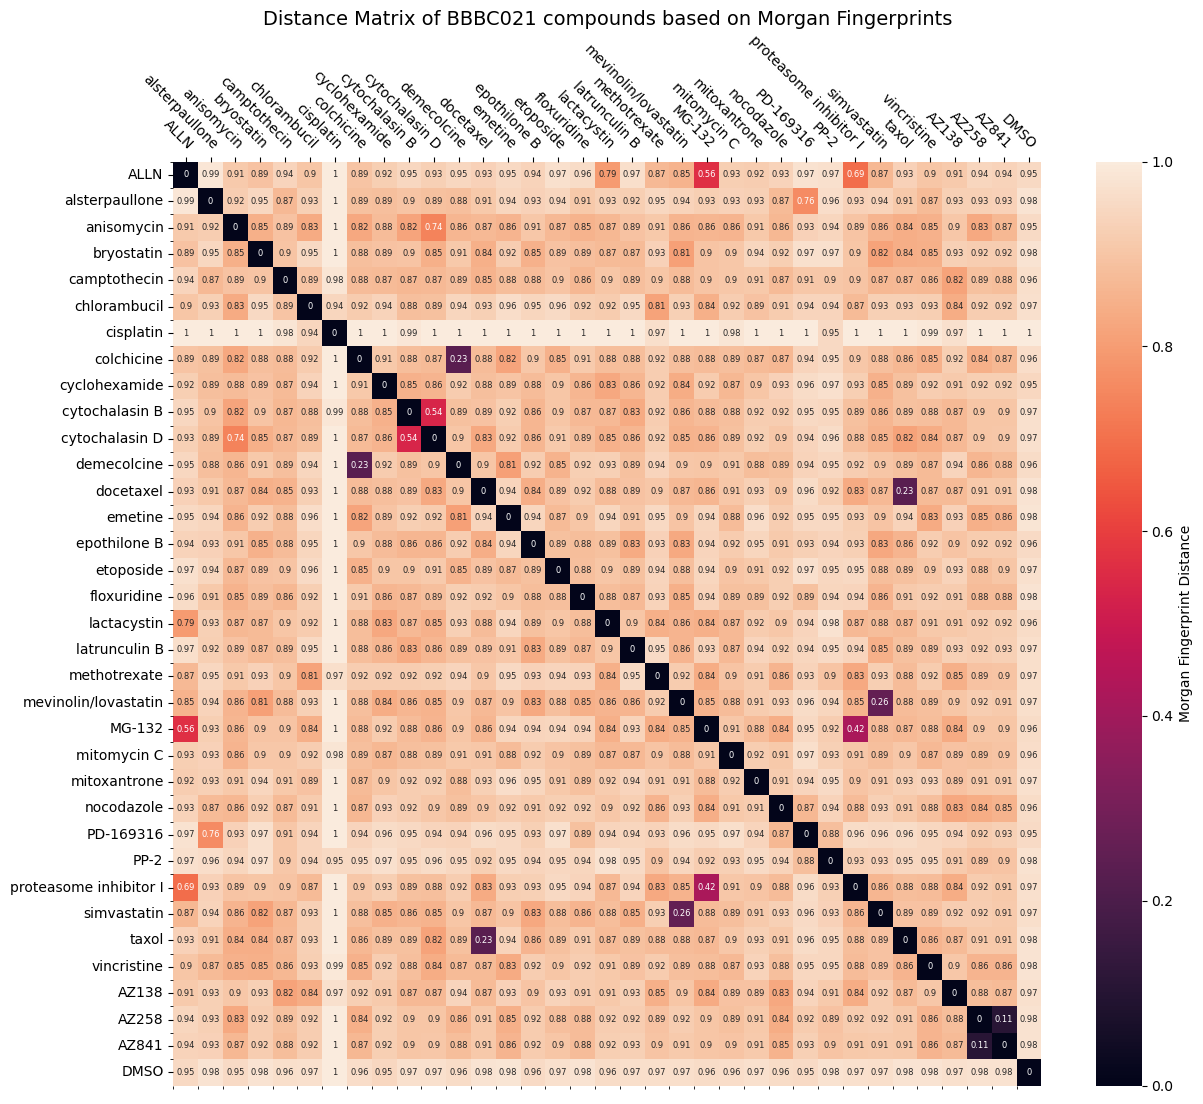

In [54]:
fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(distance_matrix, 
            annot=True, 
            annot_kws={"fontsize":6, "ha": "center"}, 
            fmt=".2g", 
            cbar_kws={'label': 'Morgan Fingerprint Distance'}, 
            ax=ax)
ax.set_yticks(range(len(fingerprints)), minor=True)
ax.set_yticklabels(compounds)
ax.set_xticks(range(len(fingerprints)), minor=True)
ax.set_xticklabels(compounds)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title("Distance Matrix of BBBC021 compounds based on Morgan Fingerprints", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.show()

In [56]:
fig.savefig(os.path.join(image_dir, "FP_distance_matrix.png"))

In [57]:
def generate_moa_dist_matrix(df, moa, ax):
    cmpd_list = df[df["Image_Metadata_MoA"] == moa]["Image_Metadata_Compound"].to_numpy()
    cmpd_idx = [i for i, c in enumerate(compounds) if c in cmpd_list]
    moa_dist = np.zeros((len(cmpd_idx), len(cmpd_idx)))
    for k in range(len(cmpd_idx)):
        for l in range(len(cmpd_idx)):
            moa_dist[k][l] = distance_matrix[cmpd_idx[k]][cmpd_idx[l]]

    sns.heatmap(moa_dist, 
                annot=True, 
                annot_kws={"fontsize":8, "ha": "center"}, 
                fmt=".4g", 
                cbar_kws={'label': 'Morgan Fingerprint Distance', 'shrink': 0.6},
                vmin=0.0,
                vmax=1.0,
                square=True,
                ax=ax)
    ax.set_yticks(range(len(cmpd_idx)), minor=True)
    ax.set_yticklabels(cmpd_list)
    ax.set_xticks(range(len(cmpd_idx)), minor=True)
    ax.set_xticklabels(cmpd_list)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_title(f"Distance Matrix MoA - {moa}", fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

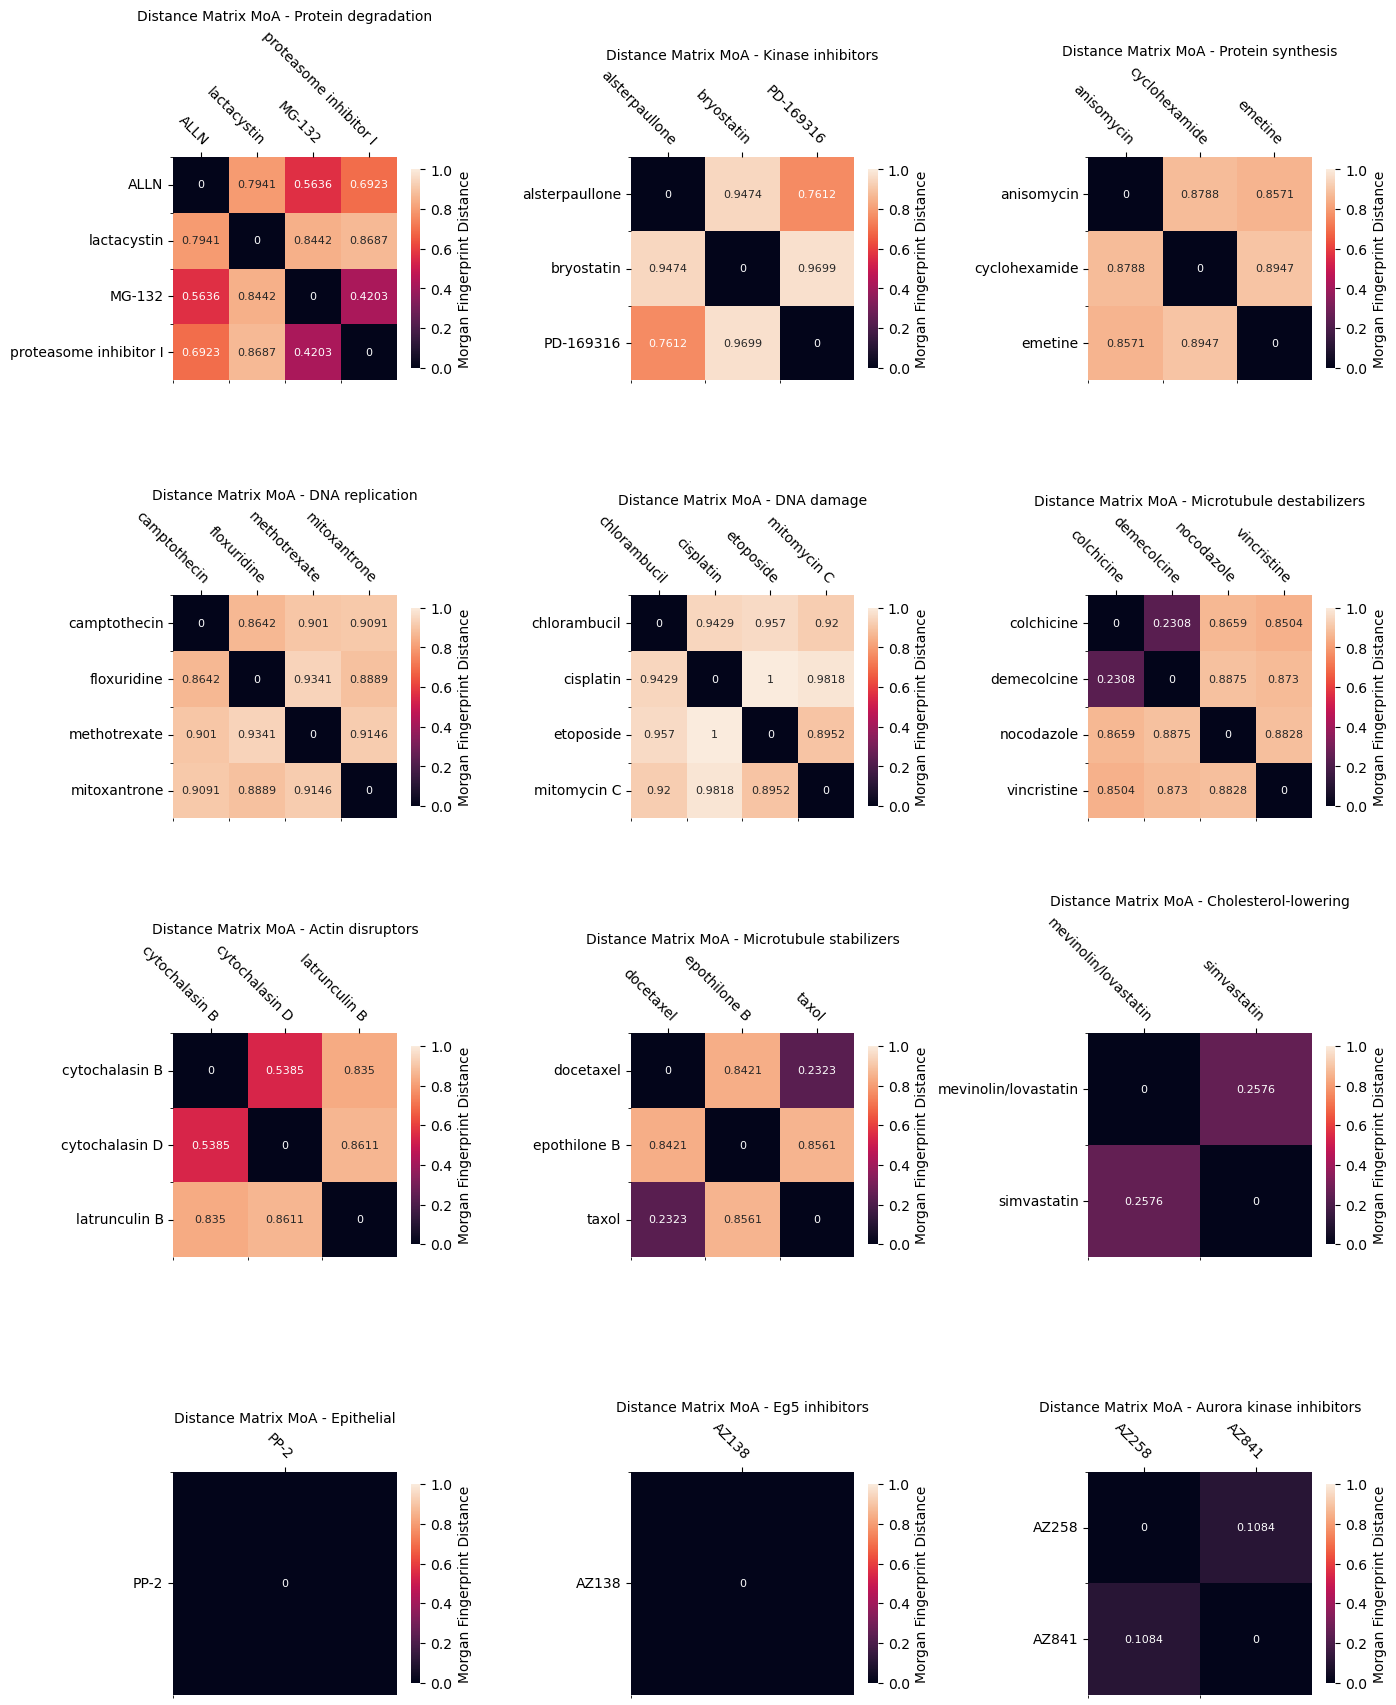

In [58]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,18))
for i, ax in enumerate(axes.flat):
    if moas[i] == "DMSO":
        continue
    # print(moas[i])
    generate_moa_dist_matrix(df_cmpds_original, moas[i], ax)
plt.tight_layout()
plt.show()

In [62]:
fig.savefig(os.path.join(image_dir, "FP_distance_matrix_by_MoA.png"))